# import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder      
from sklearn.model_selection import KFold   
import seaborn as sns
from statistics import mean
import joblib 

# load in the file 

In [2]:
dataset = pd.read_csv(r'D:\Ngan\rmit\AI\ASM3\global_bleaching_environmental.csv')

C:\Users\HP\AppData\Local\Temp\ipykernel_14328\764645299.py:1: DtypeWarning: Columns (13,15,24) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(r'D:\Ngan\rmit\AI\ASM3\global_bleaching_environmental.csv')


<div>
    <b> Problem Statement: </b>
</div>
find the bleaching percentage of coral 
<div style="color: #000; text-align: center;">
    <h1> EDA: Exploratory Data Analysis </h1>
</div>

+ understand features, datatypes, number of samples

+ are there missing values? outliers?
+ data balanced? unbalanced?
+ correlations
+ what is the label? Method?

In [ ]:
dataset.head()

In [ ]:
dataset.info()

It shows we have 8 number dtypes and 54 object dtype. Machine learning model cannot handle Object so we have to converted to Catogorical or Numeric.

In [3]:
dataset.shape

(41361, 62)

### Data Overview using ydata

In [ ]:
from ydata_profiling import ProfileReport
from ipywidgets import widgets

In [ ]:
profile = ProfileReport(dataset, title = 'Data Overview')
profile.to_notebook_iframe()
#profile.to_widgets()

There are 9 categorical features, 8 numeric features, 41 text features, 3 unsupported and 1 datetime type.
Overall we have 41361 samples and 62 columns.

The text datatype can be removed and the categorical features can be handled by One Hot Encoder.

There are 8 duplicated rows which can be removed.
The missing data is presented as 'nd'. There are 221500 'nd's in the dataset.

In [4]:
count =0
for i in dataset:
    for j in dataset[i]:
        if(j == 'nd'):
            count+=1

print(count)

221500


All features are:

In [5]:
features = dataset.columns
features

Index(['Site_ID', 'Sample_ID', 'Data_Source', 'Latitude_Degrees',
       'Longitude_Degrees', 'Ocean_Name', 'Reef_ID', 'Realm_Name',
       'Ecoregion_Name', 'Country_Name', 'State_Island_Province_Name',
       'City_Town_Name', 'Site_Name', 'Distance_to_Shore', 'Exposure',
       'Turbidity', 'Cyclone_Frequency', 'Date_Day', 'Date_Month', 'Date_Year',
       'Depth_m', 'Substrate_Name', 'Percent_Cover', 'Bleaching_Level',
       'Percent_Bleaching', 'ClimSST', 'Temperature_Kelvin',
       'Temperature_Mean', 'Temperature_Minimum', 'Temperature_Maximum',
       'Temperature_Kelvin_Standard_Deviation', 'Windspeed', 'SSTA',
       'SSTA_Standard_Deviation', 'SSTA_Mean', 'SSTA_Minimum', 'SSTA_Maximum',
       'SSTA_Frequency', 'SSTA_Frequency_Standard_Deviation',
       'SSTA_FrequencyMax', 'SSTA_FrequencyMean', 'SSTA_DHW',
       'SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 'TSA',
       'TSA_Standard_Deviation', 'TSA_Minimum', 'TSA_Maximum', 'TSA_Mean',
       'TSA_Freq

Look through the histogram of each feature, we can see the distribution and understand if the feature is balanced or not.



### Data overview using scatter plot

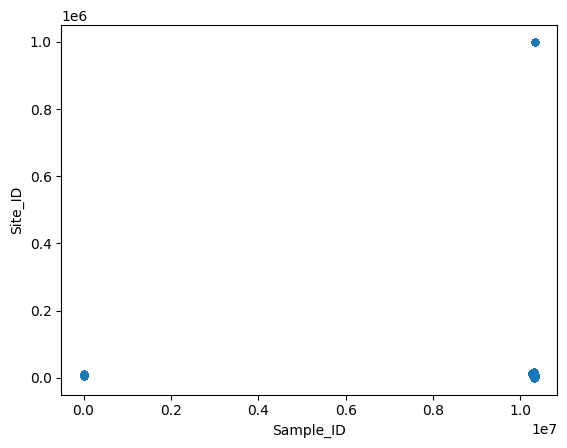

<Figure size 640x480 with 0 Axes>

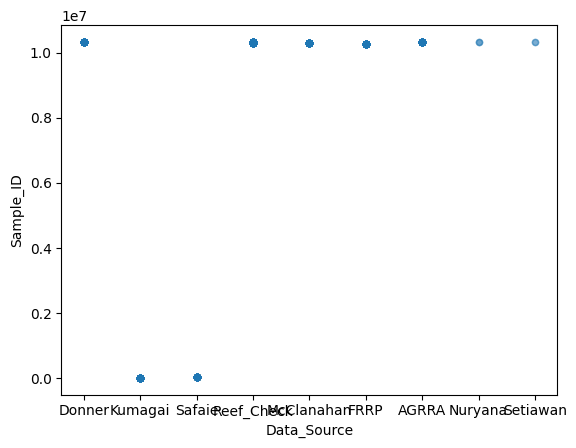

<Figure size 640x480 with 0 Axes>

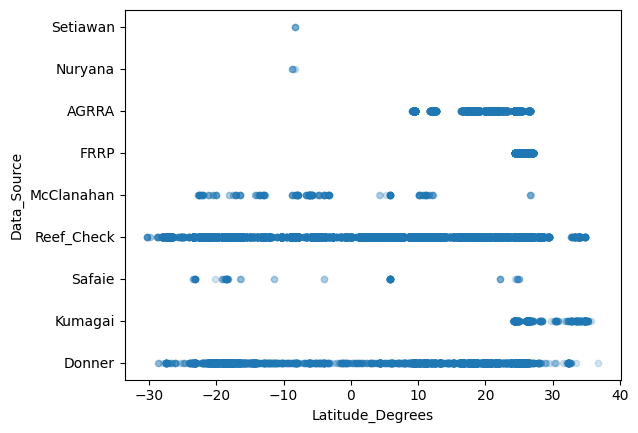

<Figure size 640x480 with 0 Axes>

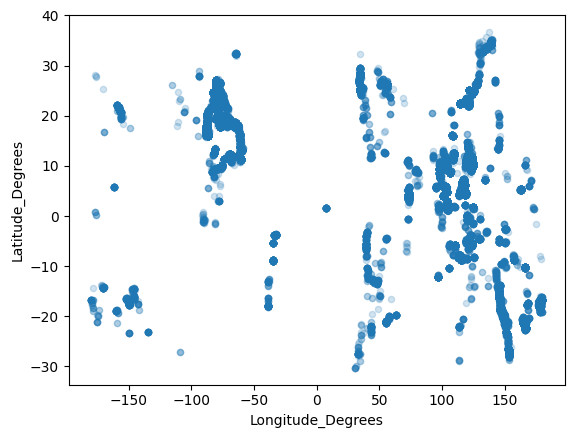

<Figure size 640x480 with 0 Axes>

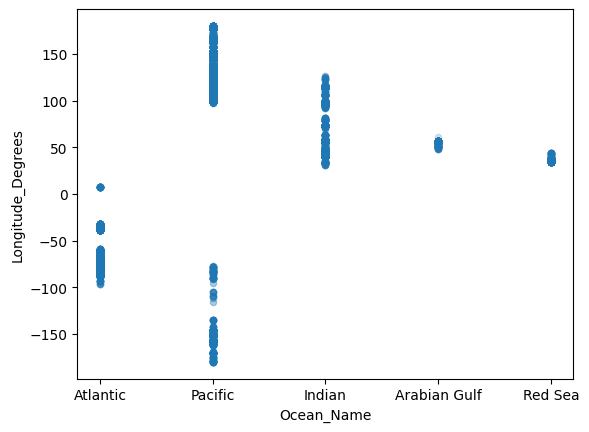

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [6]:
for i in range(len(dataset.select_dtypes('number').columns)):
    j = i+1
    dataset.plot(kind="scatter", y=i, x=j, alpha=0.2)
    #plt.axis([0, 5, 0, 10000])
    j+=1
    plt.show()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

In [ ]:
pd.plotting.scatter_matrix(dataset)
plt.show()

In [ ]:
dataset[features].hist(bins=20)
plt.show()

# Data Preprocessing
+ drop duplicates and unnecessary features
+ handle text features that has the datatype Object
+ handle missing values

## Drop duplicated rows

In [ ]:
#handle duplicate
dataset = dataset.drop_duplicates()

## Drop unnecessary features

First, we drop text features: 'Country_Name','State_Island_Province_Name','City_Town_Name','Site_Name','Ecoregion_Name'

Then we remove all the ID information including Site, Sample, Reef, and comments

We have already had a Day, Month, Year column so 'Date' is unnecessary.

After the exploratory phase, we find out some categorical features only have 1 unique value so we will remove those as well.

In [ ]:
dataset = dataset.drop(columns= ['Country_Name','State_Island_Province_Name','City_Town_Name','Site_Name','Ecoregion_Name'])
dataset = dataset.drop(columns= ['Site_ID','Sample_ID', 'Reef_ID', 'Site_Comments', 'Sample_Comments', 'Bleaching_Comments'])
dataset = dataset.drop(columns= ['Date'])
dataset = dataset.drop(columns= ['Bleaching_Level', 'SSTA_Mean'])

## Handling features that have dtype Object


These are unique values in each feature and their count.

In [ ]:
for i in dataset.select_dtypes(include='object').columns:
    print(dataset[i].unique())
    print(dataset[i].nunique())
    print('_______'*10)

Looking at the analysis, we see some numeric features having 'nd', which makes it become text type. We will inpute the 'nd' with nan to make it number-only features. Then we converted into numeric.

In [ ]:
dataset = dataset.replace('nd', np.nan)

Convert the features to numeric

In [ ]:
dataset['Percent_Cover'] = pd.to_numeric(dataset["Percent_Cover"], errors="coerce")
dataset['Depth_m'] = pd.to_numeric(dataset["Depth_m"], errors="coerce")
dataset['ClimSST'] = pd.to_numeric(dataset["ClimSST"], errors="coerce")

dataset['Temperature_Kelvin'] = pd.to_numeric(dataset["Temperature_Kelvin"], errors="coerce")
dataset['Temperature_Mean'] = pd.to_numeric(dataset["Temperature_Mean"], errors="coerce")
dataset['Temperature_Minimum'] = pd.to_numeric(dataset["Temperature_Minimum"], errors="coerce")
dataset['Temperature_Maximum'] = pd.to_numeric(dataset["Temperature_Maximum"], errors="coerce")
dataset['Temperature_Kelvin_Standard_Deviation'] = pd.to_numeric(dataset["Temperature_Kelvin_Standard_Deviation"], errors="coerce")

dataset['Windspeed'] = pd.to_numeric(dataset["Windspeed"], errors="coerce")

dataset['SSTA'] = pd.to_numeric(dataset["SSTA"], errors="coerce")
dataset['SSTA_Standard_Deviation'] = pd.to_numeric(dataset["SSTA_Standard_Deviation"], errors="coerce")
dataset['SSTA_Minimum'] = pd.to_numeric(dataset["SSTA_Minimum"], errors="coerce")
dataset['SSTA_Maximum'] = pd.to_numeric(dataset["SSTA_Maximum"], errors="coerce")

dataset['SSTA_Frequency'] = pd.to_numeric(dataset["SSTA_Frequency"], errors="coerce")
dataset['SSTA_Frequency_Standard_Deviation'] = pd.to_numeric(dataset["SSTA_Frequency_Standard_Deviation"], errors="coerce")
dataset['SSTA_FrequencyMax'] = pd.to_numeric(dataset["SSTA_FrequencyMax"], errors="coerce")
dataset['SSTA_FrequencyMean'] = pd.to_numeric(dataset["SSTA_FrequencyMean"], errors="coerce")

dataset['SSTA_DHW'] = pd.to_numeric(dataset["SSTA_DHW"], errors="coerce")
dataset['SSTA_DHW_Standard_Deviation'] = pd.to_numeric(dataset["SSTA_DHW_Standard_Deviation"], errors="coerce")
dataset['SSTA_DHWMax'] = pd.to_numeric(dataset["SSTA_DHWMax"], errors="coerce")
dataset['SSTA_DHWMean'] = pd.to_numeric(dataset["SSTA_DHWMean"], errors="coerce")

dataset['TSA'] = pd.to_numeric(dataset["TSA"], errors="coerce")
dataset['TSA_Standard_Deviation'] = pd.to_numeric(dataset["TSA_Standard_Deviation"], errors="coerce")
dataset['TSA_Minimum'] = pd.to_numeric(dataset["TSA_Minimum"], errors="coerce")
dataset['TSA_Maximum'] = pd.to_numeric(dataset["TSA_Maximum"], errors="coerce")
dataset['TSA_Mean'] = pd.to_numeric(dataset["TSA_Mean"], errors="coerce")

dataset['TSA_Frequency'] = pd.to_numeric(dataset["TSA_Frequency"], errors="coerce")
dataset['TSA_Frequency_Standard_Deviation'] = pd.to_numeric(dataset["TSA_Frequency_Standard_Deviation"], errors="coerce")
dataset['TSA_FrequencyMax'] = pd.to_numeric(dataset["TSA_FrequencyMax"], errors="coerce")
dataset['TSA_FrequencyMean'] = pd.to_numeric(dataset["TSA_FrequencyMean"], errors="coerce")

dataset['TSA_DHW'] = pd.to_numeric(dataset["TSA_DHW"], errors="coerce")
dataset['TSA_DHW_Standard_Deviation'] = pd.to_numeric(dataset["TSA_DHW_Standard_Deviation"], errors="coerce")
dataset['TSA_DHWMax'] = pd.to_numeric(dataset["TSA_DHWMax"], errors="coerce")
dataset['TSA_DHWMean'] = pd.to_numeric(dataset["TSA_DHWMean"], errors="coerce")

dataset['Distance_to_Shore'] = pd.to_numeric(dataset["Distance_to_Shore"], errors="coerce")
dataset['Turbidity'] = pd.to_numeric(dataset["Turbidity"], errors="coerce")
dataset['Percent_Bleaching'] = pd.to_numeric(dataset["Percent_Bleaching"], errors="coerce")



Hence, the number of numeric features go up to 41: 
- 'Latitude_Degrees','Longitude_Degrees', 'Cyclone_Frequency','Date_Day', 'Date_Month', 'Date_Year'
- 'Percent_Cover','Depth_m','ClimSST',
- 'Temperature_Kelvin','Temperature_Mean','Temperature_Minimum','Temperature_Maximum',
'Temperature_Kelvin_Standard_Deviation',
- 'Windspeed',
- 'SSTA','SSTA_Standard_Deviation', 'SSTA_Minimum','SSTA_Maximum',
- 'SSTA_Frequency',
'SSTA_Frequency_Standard_Deviation','SSTA_FrequencyMax','SSTA_FrequencyMean',
- 'SSTA_DHW','SSTA_DHW_Standard_Deviation','SSTA_DHWMax','SSTA_DHWMean',
- 'TSA','TSA_Standard_Deviation','TSA_Minimum','TSA_Maximum','TSA_Mean',
- 'TSA_Frequency','TSA_Frequency_Standard_Deviation','TSA_FrequencyMax','TSA_FrequencyMean',
- 'TSA_DHW','TSA_DHW_Standard_Deviation','TSA_DHWMax','TSA_DHWMean'
- 'Distance_to_Shore','Turbidity','Percent_Bleaching'


In [ ]:
num_fea = dataset.select_dtypes(include='number').columns
num_fea

## Handle outliers

### Identify outliers using box plots


In [ ]:
for i in range(len(num_fea)):
    sns.boxplot(dataset[num_fea[i]])
    plt.show()


We detect outliers by z-score method. This method standardizes with mean and standard deviations, and enables to compare values across different distributions. After that, we handle it by clipping.

In [ ]:
#handle outliers with z-score


outlier = []
def outliers_Z(data):
    threshold = 3
    count = 0

    for i in data:
        mean = np.mean(data[i]) 
        std = np.std(data[i])
        for j in data[i]:
         
            z = (j-mean)/std 
            if np.abs(z) > threshold: 
                # notice outliers and remove it
                data = data[data[i] != j]
                count+=1
    return data


Update the dataset

In [ ]:

dataset_after_outliers = outliers_Z(dataset.select_dtypes("number"))
dataset_after_outliers

In [ ]:
dataset = dataset.merge(dataset_after_outliers, how='left')

In [ ]:
dataset.shape

## Split dataset into train and test set

In [ ]:
from sklearn.model_selection import train_test_split                                                                                     # otherwise, when repeating training many times, your model may see all the data

In [ ]:
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=17) # set random_state to get the same training set all the time, 


As we need to predict percent beaching of coral reef, our label is 'Percent_Beaching'

In [ ]:
train_set_labels = train_set['Percent_Bleaching'].copy()
train_set = train_set.drop(columns = "Percent_Bleaching") 
test_set_labels = test_set["Percent_Bleaching"].copy()
test_set = test_set.drop(columns = "Percent_Bleaching") 

## Transform categorical features with OneHotEncoder

Identify categorical features

In [ ]:
cat_fea = ['Exposure','Substrate_Name', 'Data_Source','Ocean_Name','Realm_Name']

Set up OneHot Encoder

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
ohetransform = ohe.fit_transform(dataset[cat_fea])

In [ ]:
processed_train_set_val = pd.concat([train_set,ohetransform], axis=1, join='outer').drop(columns=cat_fea)

In [ ]:
processed_train_set_val.head()

After changing all the categorical features into numbers with OneHot Encoder, the training dataset only has numeric features. To make sure, we will drop all 'object' datatype columns.

In [ ]:
object_col = processed_train_set_val.select_dtypes('object').columns
processed_train_set_val.drop(object_col)

## Handling missing data

We use the heatmap to see the distribution of missing values

In [ ]:
sns.heatmap(dataset.isnull(), yticklabels=False, cbar=False, cmap='viridis')

We will handle missing data for these following numeric features:

In [ ]:
num_cols = ['Latitude_Degrees', 'Longitude_Degrees', 'Distance_to_Shore',
       'Turbidity', 'Cyclone_Frequency', 'Date_Day', 'Date_Month', 'Date_Year',
       'Percent_Cover', 'ClimSST', 'Temperature_Kelvin',
       'Temperature_Mean', 'Temperature_Minimum', 'Temperature_Maximum',
       'Temperature_Kelvin_Standard_Deviation', 'Windspeed', 'SSTA',
       'SSTA_Standard_Deviation', 'SSTA_Minimum', 'SSTA_Maximum',
       'SSTA_Frequency', 'SSTA_Frequency_Standard_Deviation',
       'SSTA_FrequencyMax', 'SSTA_FrequencyMean', 'SSTA_DHW',
       'SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 'TSA',
       'TSA_Standard_Deviation', 'TSA_Minimum', 'TSA_Maximum', 'TSA_Mean',
       'TSA_Frequency', 'TSA_Frequency_Standard_Deviation', 'TSA_FrequencyMax',
       'TSA_FrequencyMean', 'TSA_DHW', 'TSA_DHW_Standard_Deviation',
       'TSA_DHWMax', 'TSA_DHWMean', 'Depth_m']

We can use isnull() and sum() to see the total numbers of missing values of each feature

In [ ]:
train_set[num_cols].isnull().sum()

We see the missing values of each feature and need to understand the reasons for the missing:
- MCAR: Completely random, no relationship
- MNAR: can be explained by not-null variable
- MAR: not at random, related to unobserved data

In [ ]:
for i in num_cols:
    processed_train_set_val[i] = processed_train_set_val[i].fillna(np.mean(train_set[i]) )

In [ ]:
processed_train_set_val.isnull().sum().sum()

In [ ]:
processed_train_set_val.head()

Prepare a Pipeline to transform data, ready to train model

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, dataframe, labels=None):
        return self
    def transform(self, dataframe):
        return dataframe[self.feature_names].values  

In [ ]:
pipeline = Pipeline([
    ('selector', ColumnSelector(processed_train_set_val.columns)),
    ])  

In [ ]:
processed_train_set_val = pipeline.fit_transform(processed_train_set_val)
print(processed_train_set_val.shape)

print('\n____________ Processed feature values ____________')
print(processed_train_set_val[[0, 1, 2],:].toarray())

## Training

Storing the models

In [ ]:
# Store models to files, to compare latter
#from sklearn.externals import joblib 
import joblib # new lib
def store_model(model, model_name = ""):
    # NOTE: sklearn.joblib faster than pickle of Python
    # INFO: can store only ONE object in a file
    if model_name == "": 
        model_name = type(model).__name__
    joblib.dump(model,'models/' + model_name + '_model.pkl')
def load_model(model_name):
    # Load objects into memory
    #del model
    model = joblib.load('models/' + model_name + '_model.pkl')
    #print(model)
    return model

Performance measure

In [ ]:
# Compute R2 score and root mean squared error
def r2score_and_rmse(model, train_data, labels): 
    r2score = model.score(train_data, labels)
    from sklearn.metrics import mean_squared_error
    prediction = model.predict(train_data)
    mse = mean_squared_error(labels, prediction)
    rmse = np.sqrt(mse)
    return r2score, rmse      


Linear Regression model

In [ ]:
# Training: learn a linear regression hypothesis using training data 
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(processed_train_set_val, train_set_labels)
print('\n____________ LinearRegression ____________')
print('Learned parameters: ', model.coef_, model.intercept_)

store_model(model)


Decision Tree Regressor Model

In [ ]:
# Training
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(processed_train_set_val, train_set_labels)

# Compute R2 score and root mean squared error
print('\n____________ DecisionTreeRegressor ____________')
r2score, rmse = r2score_and_rmse(model, processed_train_set_val, train_set_labels)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse.round(decimals=1))
store_model(model)

# Predict labels for some training instances
#print("Input data: \n", train_set.iloc[0:9])
print("\nPredictions: ", model.predict(processed_train_set_val[0:9]).round(decimals=1))
print("Labels:      ", list(train_set_labels[0:9]))


Random Forest Regressor Model

In [ ]:
# Training (NOTE: may take time if train_set is large)
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 5) # n_estimators: no. of trees
model.fit(processed_train_set_val, train_set_labels)

# Compute R2 score and root mean squared error
print('\n____________ RandomForestRegressor ____________')
r2score, rmse = r2score_and_rmse(model, processed_train_set_val, train_set_labels)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse.round(decimals=1))
store_model(model)      

# Predict labels for some training instances
#print("Input data: \n", train_set.iloc[0:9])
print("\nPredictions: ", model.predict(processed_train_set_val[0:9]).round(decimals=1))
print("Labels:      ", list(train_set_labels[0:9]))



Polinomial Regression Model

In [ ]:
# NOTE: polinomial regression can be treated as (multivariate) linear regression where high-degree features x1^2, x2^2, x1*x2... are seen as new features x3, x4, x5... 
# hence, to do polinomial regression, we add high-degree features to the data, then call linear regression
# 5.5.1 Training. NOTE: may take a while 
from sklearn.preprocessing import PolynomialFeatures
poly_feat_adder = PolynomialFeatures(degree = 2) # add high-degree features to the data
train_set_poly_added = poly_feat_adder.fit_transform(processed_train_set_val)
new_training = 10
if new_training:
    model = LinearRegression()
    model.fit(train_set_poly_added, train_set_labels)
    store_model(model, model_name = "PolinomialRegression")      
else:
    model = load_model("PolinomialRegression")

# 5.4.2 Compute R2 score and root mean squared error
print('\n____________ Polinomial regression ____________')
r2score, rmse = r2score_and_rmse(model, train_set_poly_added, train_set_labels)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse.round(decimals=1))

# 5.4.3 Predict labels for some training instances
print("\nPredictions: ", model.predict(train_set_poly_added[0:9]).round(decimals=1))
print("Labels:      ", list(train_set_labels[0:9]))


In [ ]:




#%% 5.4 Try 


#%% 5.5 Evaluate with K-fold cross validation 
from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
#from sklearn.model_selection import cross_val_predict

#cv1 = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42); 
#cv2 = StratifiedKFold(n_splits=10, random_state=42); 
#cv3 = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42); 
print('\n____________ K-fold cross validation ____________')

run_new_evaluation = 0
if run_new_evaluation:
    from sklearn.model_selection import KFold, StratifiedKFold
    # NOTE: 
    #   + If data labels are float, cross_val_score use KFold() to split cv data.
    #   + KFold randomly splits data, hence does NOT ensure data splits are the same (only StratifiedKFold may ensure that)
    cv = KFold(n_splits=5,shuffle=True,random_state=37) # cv data generator: just a try to persist data splits (hopefully)

    # Evaluate LinearRegression
    model_name = "LinearRegression" 
    model = LinearRegression()             
    nmse_scores = cross_val_score(model, processed_train_set_val, train_set_labels, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    print("LinearRegression rmse: ", rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)),'\n')

    # Evaluate DecisionTreeRegressor
    model_name = "DecisionTreeRegressor" 
    model = DecisionTreeRegressor()
    nmse_scores = cross_val_score(model, processed_train_set_val, train_set_labels, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    print("DecisionTreeRegressor rmse: ", rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)),'\n')

    # Evaluate RandomForestRegressor
    model_name = "RandomForestRegressor" 
    model = RandomForestRegressor(n_estimators = 5)
    nmse_scores = cross_val_score(model, processed_train_set_val, train_set_labels, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    print("RandomForestRegressor rmse: ", rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)),'\n')

    # Evaluate Polinomial regression
    model_name = "PolinomialRegression" 
    model = LinearRegression()
    nmse_scores = cross_val_score(model, train_set_poly_added, train_set_labels, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    print("Polinomial regression rmse: ", rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)),'\n')
else:
    # Load rmse
    model_name = "LinearRegression" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("\nLinearRegression rmse: ", rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)),'\n')

    model_name = "DecisionTreeRegressor" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("DecisionTreeRegressor rmse: ", rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)),'\n')

    model_name = "RandomForestRegressor" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("RandomForestRegressor rmse: ", rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)),'\n')

    model_name = "PolinomialRegression" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("Polinomial regression rmse: ", rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)),'\n')


See the performance